In [ ]:
import cv2
import os

# Carpeta con las imágenes originales de la secuencia
images_dir = "../Fluo-N2DL-HeLa (1)"

# Archivo de detecciones generado por predict.py
detections_file = "output/MAX230426_bCatTracking_Exp91_20230426_73604 AM_f0000_t0000.txt"

# Carpeta de salida para imágenes con cuadros
output_dir = "output/visual/3T3-run02"
os.makedirs(output_dir, exist_ok=True)

# Leer detecciones
detections = {}
with open(detections_file) as f:
    for line in f:
        frame_id, obj_id, x, y, w, h, conf, _, _ = map(float, line.strip().split(','))
        frame_id = int(frame_id)
        detections.setdefault(frame_id, []).append((x, y, w, h))

# Dibujar cajas
for frame_id, boxes in detections.items():
    img_path = os.path.join(images_dir, f"{frame_id:06d}.jpg")
    if not os.path.exists(img_path):
        continue
    img = cv2.imread(img_path)
    for x, y, w, h in boxes:
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    cv2.imwrite(os.path.join(output_dir, f"{frame_id:06d}.jpg"), img)


In [9]:
import cv2
import os
import tifffile as tiff
import numpy as np

# Archivo TIFF con la secuencia de frames
images_file = "./videos/MAX230426_bCatTracking_Exp91_20230426_73604 AM_f0009_t0000.tif"

# Archivo de detecciones generado por predict.py
detections_file = "output/MAX230426_bCatTracking_Exp91_20230426_73604 AM_f0009_t0000.txt"

# Carpeta de salida para imágenes con cuadros
output_dir = "output/visual/imagenes9"
os.makedirs(output_dir, exist_ok=True)

# Leer todos los frames del TIFF
frames_raw = tiff.imread(images_file)
frames = []

for i, f in enumerate(frames_raw):
    # Normalizar a 0-255
    f = ((f - f.min()) / (f.max() - f.min()) * 255).astype(np.uint8)
    
    # Asegurarse de que tenga 3 canales y en BGR para OpenCV
    if f.ndim == 2:  # gris
        f_bgr = np.stack([f]*3, axis=-1)
    elif f.ndim == 3 and f.shape[2] == 1:  # gris con canal extra
        f_bgr = np.concatenate([f]*3, axis=2)
    elif f.ndim == 3 and f.shape[2] == 3:  # RGB → BGR
        f_bgr = cv2.cvtColor(f, cv2.COLOR_RGB2BGR)
    else:
        raise ValueError(f"Frame {i} tiene un shape inesperado: {f.shape}")
    
    frames.append(f_bgr)

# Leer detecciones
detections = {}
with open(detections_file) as f:
    for line in f:
        frame_id, obj_id, x, y, w, h, conf, _, _ = map(float, line.strip().split(','))
        frame_id = int(frame_id)
        detections.setdefault(frame_id, []).append((x, y, w, h))

# Dibujar cajas y guardar imágenes
for frame_id, boxes in detections.items():
    if frame_id >= len(frames):
        print(f"Frame {frame_id} no existe en el TIFF")
        continue
    img = frames[frame_id].copy()
    for x, y, w, h in boxes:
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    output_path = os.path.join(output_dir, f"{frame_id:06d}.jpg")
    cv2.imwrite(output_path, img)

print("¡Listo! Imágenes guardadas en:", output_dir)


Frame 99 no existe en el TIFF
¡Listo! Imágenes guardadas en: output/visual/imagenes9


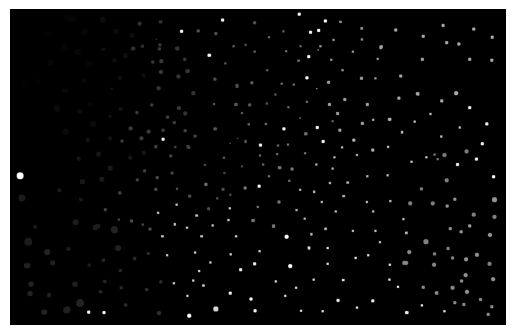

In [28]:
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2
import numpy as np

img = tiff.imread("../Fluo-N2DL-HeLa (1)/Fluo-N2DL-HeLa/02_GT/TRA/man_track091.tif")
cv2.imwrite("test_normalized.png", img)

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

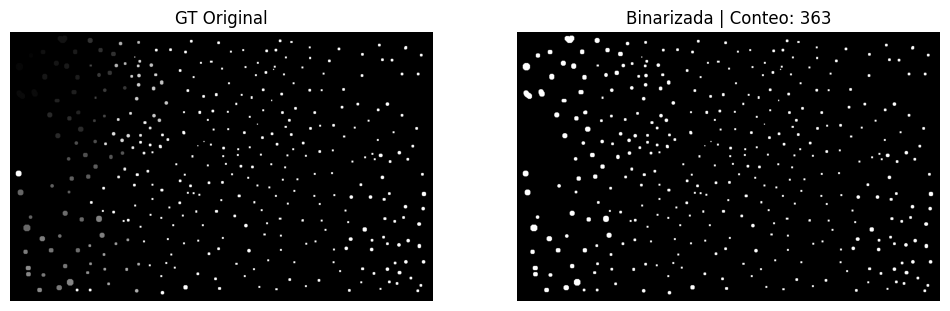

In [27]:
import os
import glob
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label

# ================================================================
#   PIPELINE B  →  Procesamiento de Ground Truth
# ================================================================
def binarize_and_count(gt_path):
    """Carga GT, binariza todo >0 como célula y cuenta objetos."""
    img = tiff.imread(gt_path)

    if img.ndim == 3:
        img = img[0]  # GT a veces viene como stack

    # Convertir a rango visible sin alterar labels
    if img.dtype == np.uint16:
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Binarización simple
    _, binary = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

    # Conteo de objetos conectados
    num_labels = label(binary).max()
    return img, binary, num_labels

# ================================================================
#   VISUALIZACIÓN DE UNA IMAGEN
# ================================================================
def visualize_gt(gt_path):
    original, binary, count = binarize_and_count(gt_path)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(original, cmap='gray')
    plt.title('GT Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(binary, cmap='gray')
    plt.title(f'Binarizada | Conteo: {count}')
    plt.axis('off')

    plt.show()

# ================================================================
#   EJEMPLO DE USO
# ================================================================
if __name__ == "__main__":
    # Cambiar al directorio de Ground Truth
    gt_dir = "../Fluo-N2DL-HeLa (1)/Fluo-N2DL-HeLa/02_GT/TRA"
    gt_files = sorted(glob.glob(os.path.join(gt_dir, "*.tif")))

    # Elegimos la primera imagen para prueba
    visualize_gt(gt_files[90])

    # Si querés, podés recorrer varias imágenes:
    # for gt_path in gt_files[:5]:
    #     visualize_gt(gt_path)
